## Benchmarking heuristic method for reducing edit distance search space

In [1]:
import random
import copy
import sys
import itertools as it
from random import shuffle
from collections import Counter, defaultdict
import pysam
import click
import networkx as nx


def edit_distance(umi_a, umi_b):
    '''
    Hamming distance between two sequences.
    '''
    return sum(a != b for a, b in zip(umi_a, umi_b))


def test_count_ratio(count_a, count_b):
    '''
    sort counts and determine if they fulfill the expression:
    larger > 2 * smaller - 1
    '''
    count_a, count_b = sorted([count_a, count_b], reverse=True)
    if count_a > (2 * count_b - 1):
        return True
    else:
        return False


def build_substr_idx(umis, sub_size, idx_size):
    '''
    Build a dictionary of nearest neighbours using substrings, can be used
    to heuristically reduce the number of pairwise comparisons.

    see:
    https://cs.stackexchange.com/questions/73865/approximate-similarity-search
    for more details.
    '''
    # create index for string where sub_size chars are selected
    idx = sub_size * [1, ] + (len(umis[0]) - sub_size) * [0, ]
    substr_idx = defaultdict(lambda: defaultdict(set))
    for _ in range(idx_size):
        # each section of the substr_idx uses different random substrings of
        # the same length.
        shuffle(idx)
        idx_tup = tuple(idx)
        for u in umis:
            u_sub = ''.join(n for i, n in zip(idx, u) if i)
            substr_idx[idx_tup][u_sub].add(u)
    return substr_idx


def get_umi_neighbours(u, substr_idx):
    '''
    use substring dict to get (approximately) all the nearest neighbours to a
    umi.
    '''
    neighbours = set()
    for idx, substr_map in substr_idx.items():
        u_sub = ''.join(n for i, n in zip(idx, u) if i)
        neighbours = neighbours.union(substr_map[u_sub])
    neighbours.remove(u)
    return neighbours

def create_groups_heuristic(umis, min_edit, substr_size, index_size):
    umi_counts = Counter(umis)
    substr_idx = build_substr_idx(list(umi_counts.keys()),
                                  substr_size,
                                  index_size)
    g = nx.Graph()
    g.add_nodes_from(umi_counts)
    for umi_a in umi_counts:
        for umi_b in get_umi_neighbours(umi_a, substr_idx):
            if edit_distance(umi_a, umi_b) <= min_edit and test_count_ratio(
                    umi_counts[umi_a], umi_counts[umi_b]):
                g.add_edge(umi_a, umi_b)

    labelled_umis = {}
    n_groups = 0
    for i, subgraph in enumerate(nx.connected_components(g), start=1):
        n_groups += 1
        for umi in subgraph:
            labelled_umis[umi] = str(i)
    return labelled_umis, n_groups


def create_groups_pairwise(umis, min_edit):
    '''
    Create a network of umis connected by having less than min_edit differences
    in sequence, and return all the subgraphs of the network (as clusters of
    probable PCR duplicates).
    '''
    umi_counts = Counter(umis)
    g = nx.Graph()
    g.add_nodes_from(umi_counts)
    for umi_a, umi_b in it.combinations(umi_counts, r=2):
        if edit_distance(umi_a, umi_b) <= min_edit and test_count_ratio(
                umi_counts[umi_a], umi_counts[umi_b]):
            g.add_edge(umi_a, umi_b)

    labelled_umis = {}
    n_groups = 0
    for i, subgraph in enumerate(nx.connected_components(g), start=1):
        n_groups += 1
        for umi in subgraph:
            labelled_umis[umi] = str(i)
    return labelled_umis, n_groups

## Simulating PCR amplification and errors

In [2]:
def simulate_umi(n=10):
    return ''.join(random.choice('ACGT') for _ in range(n))

def error_prone_pcr(umis, efficiency=0.95):
    sample_size = int(len(umis) * efficiency)
    return umis + [mutate_umi(u) for u in random.sample(umis, k=sample_size)]

def mutate_umi(umi, rate=0.005):
    return ''.join(x if random.random() > rate else random.choice('ACGT')
                   for x in umi)

def run_pcr(umi_count, pcr_cycles=5):
    umis = [simulate_umi() for _ in range(umi_count)]
    for _ in range(pcr_cycles):
        umis = error_prone_pcr(umis)
    return umis

## How heuristic is the method?

Parameters used:

* UMI length - 10nt
* Minimum edit distance to connect UMIs - 1nt
* Substring size for heuristic method - 4nt

Varying the number of substring indexes used will make the method more or less heuristic

In [16]:
import numpy as np

start_umi_counts = (2, 5, 10, 25, 50, 100)
index_sizes = (1, 2, 5, 10, 15)
pairwise_ngroups = []
heuristic_ngroups = defaultdict(list)
unique_umis = []

for start_umi in start_umi_counts:
    print('Running for {} initial UMIs'.format(start_umi))
    random.seed(1001)
    umis = run_pcr(start_umi)
    unique_umis.append(len(set(umis)))

    umi_groups, n_groups = create_groups_pairwise(umis, 1)
    pairwise_ngroups.append(n_groups)
    
    for idx in index_sizes:
        n_groups_dist = []
        for _ in range(10):
            umi_groups, n_groups = create_groups_heuristic(umis, 1, 4, idx)
            n_groups_dist.append(n_groups)
        heuristic_ngroups[idx].append(np.mean(n_groups_dist))

Running for 2 initial UMIs
Running for 5 initial UMIs
Running for 10 initial UMIs
Running for 25 initial UMIs
Running for 50 initial UMIs
Running for 100 initial UMIs


The heuristic methods get an identical result to all pairwise comparisons using only 10 substring indexes. 5 indexes also comes very close. 15 is basically overkill (but safe!)

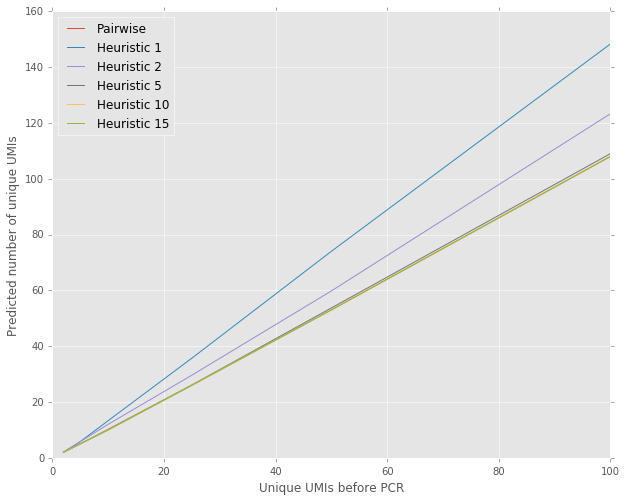

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(start_umi_counts, pairwise_ngroups, label='Pairwise')
for idx in index_sizes:
    ax.plot(start_umi_counts, heuristic_ngroups[idx],
            label='Heuristic {}'.format(idx))
ax.set(
    xlabel='Unique UMIs before PCR',
    ylabel='Predicted number of unique UMIs'
)
ax.legend(loc=0)
plt.show()

## Timing the pairwise and heuristic methods

In [14]:
from timeit import timeit

setup = '''
from random import seed
from __main__ import run_pcr, create_groups_pairwise, create_groups_heuristic
seed(1001)
umis=run_pcr({})
'''

pairwise_statement = '''
umi_groups, n_groups = create_groups_pairwise(umis, 1)
'''

heuristic_statement = '''
umi_groups, n_groups = create_groups_heuristic(umis, 1, 4, {})
'''

start_umi_counts = (2, 5, 10, 25, 50, 100)
index_sizes = (2, 5, 10, 15)
pairwise_times = []
heuristic_times = defaultdict(list)
unique_umis = []


for start_umi in start_umi_counts:
    print('Running for {} initial UMIs'.format(start_umi))
    random.seed(1001)
    umis = run_pcr(start_umi)
    unique_umis.append(len(set(umis)))
    
    setup_fmt = setup.format(start_umi)
    pairwise_times.append(timeit(stmt=pairwise_statement,
                                 setup=setup_fmt,
                                 number=100))
    for idx in index_sizes:
        heuristic_statement_fmt = heuristic_statement.format(idx)
        heuristic_times[idx].append(timeit(stmt=heuristic_statement_fmt,
                                           setup=setup_fmt,
                                           number=100))

Running for 2 initial UMIs
Running for 5 initial UMIs
Running for 10 initial UMIs
Running for 25 initial UMIs
Running for 50 initial UMIs
Running for 100 initial UMIs


The overhead for using the heuristic method varies depending on the number of substring indexes which are created. Using 10-15 indexes, the heuristic method is better than pairwise comparison for groups of more than 50 unique UMIs.

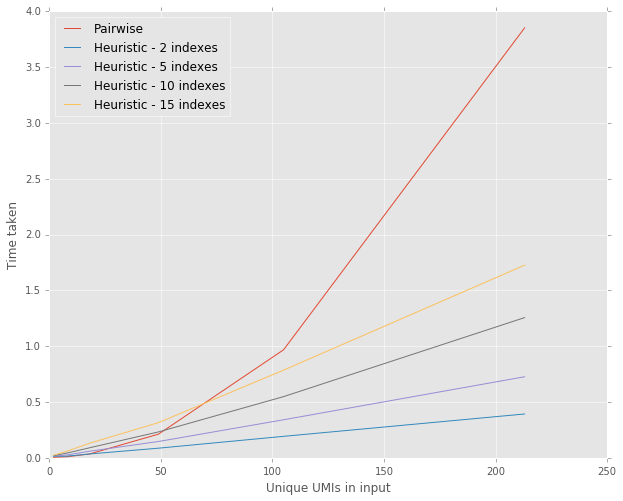

In [15]:
from matplotlib import pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(unique_umis, pairwise_times, label='Pairwise')
for idx in index_sizes:
    ax.plot(unique_umis, heuristic_times[idx],
            label='Heuristic - {} indexes'.format(idx))
ax.set(
    xlabel='Unique UMIs in input',
    ylabel='Time taken'
)
plt.legend(loc=0)
plt.show()